### Imports

In [11]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from lib import utils

### Dictionary

In [12]:
WAVES = ['delta','theta', 'alpha', 'beta', 'gamma']
MEASURES = ['absolute', 'relative']
CHANNELS = ['1','2','3','4']
COLORS = {'delta':'r', 'theta':'y', 'alpha':'g','beta':'b','gamma':'#4B0082'}
REGIONS = {'1':"Left Back", '2':'Left Front', '3':'Right Front','4':'Right Back'}

### Helper Functions

In [178]:
def plot_average(data, color='--', label=None):
    plt.plot(data['timestamps'],data["average"], color, label=label)

def plot_channel(channel,measure):
    
    sns.set(rc={'figure.figsize':(20, 8)})
    waves = []
    for wave in WAVES: waves.append(BRAINWAVES.get(wave + '_' + measure)[wave + '_' + measure + '_' + channel])
    ts = BRAINWAVES.get('delta' + '_' + measure)['timestamps']
    fig, ax = plt.subplots()
    ax.stackplot(ts, waves,labels=(WAVES),colors=(list(COLORS.values())))
    
    for wave in WAVES:
        data = BRAINWAVES.get(wave + '_' + measure)
        plt.plot(data['timestamps'],data[wave + '_' + measure + '_' + channel],COLORS[wave], label=wave)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
    plt.title(REGIONS[channel] + ' - ' + measure)

def plot_channels(measure):
    sns.set(rc={'figure.figsize':(20, 12)})
    plt.subplot(2, 2, 1) ; plot_channel('2',measure)
    plt.subplot(2, 2, 2) ; plot_channel('3',measure)
    plt.subplot(2, 2, 3) ; plot_channel('1',measure)
    plt.subplot(2, 2, 4) ; plot_channel('4',measure)

def plot_bands(measure='absolute',channel='average'):
    sns.set(rc={'figure.figsize':(20, 12)}) 
    waves = []
    
    for wave in (WAVES): waves.append(BRAINWAVES.get(wave + '_' + measure)[channel])
    ts = BRAINWAVES.get('delta' + '_' + measure)['timestamps']
    fig, ax = plt.subplots()
    
    plt.title('All Regions - ' + measure + ' power')
    ax.stackplot(ts, waves,labels=(WAVES),colors=(list(COLORS.values())))

    for wave in (WAVES): plot_average(BRAINWAVES.get(wave + '_' + measure),COLORS[wave],label=wave)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
    
def bandpower_summary():
    sf = 256

    for channel in CHANNELS:
        data = RECORDS[RECORDS['eeg_' + channel].notnull()]['eeg_' + channel]

        # Multitaper delta power
        dpr = utils.bandpower(data, sf, [0, 4], 'multitaper', relative=True)
        tpr = utils.bandpower(data, sf, [4, 8], 'multitaper', relative=True)
        apr = utils.bandpower(data, sf, [8, 12], 'multitaper', relative=True)
        bpr = utils.bandpower(data, sf, [12, 36], 'multitaper', relative=True)
        gpr = utils.bandpower(data, sf, [36, 64], 'multitaper', relative=True)
        epr = utils.bandpower(data, sf, [64, 96], 'multitaper', relative=True)
        zpr = utils.bandpower(data, sf, [96, 128], 'multitaper', relative=True)

        print(REGIONS[channel] + '\t' +
              'δ: %.3f  θ: %.3f  α: %.4f  β: %.4f  γ: %.4f  ε: %.4f  ζ: %.7f' %
              (dpr, tpr, apr, bpr, gpr, epr, zpr))

## Load EEG Data

In [14]:
RECORDS = pd.read_csv("data/test.csv",low_memory=False)

## Get Brainwaves

In [15]:
BRAINWAVES = {}

for frequency in WAVES:
    for measure in MEASURES:
        wave = frequency + '_' + measure
        waves = RECORDS[["timestamps",wave + '_1', wave +'_2', wave + '_3', wave + '_4']].dropna()
        waves['average'] = waves.loc[:, waves.columns != 'timestamps'].mean(axis=1)
        
        BRAINWAVES[wave] = waves

## Bandpower Summary

In [179]:
bandpower_summary()

Left Back	δ: 0.582  θ: 0.107  α: 0.1608  β: 0.1091  γ: 0.0285  ε: 0.0090  ζ: 0.0012312
Left Front	δ: 0.720  θ: 0.081  α: 0.0549  β: 0.0969  γ: 0.0295  ε: 0.0133  ζ: 0.0011496
Right Front	δ: 0.776  θ: 0.070  α: 0.0347  β: 0.0766  γ: 0.0246  ε: 0.0109  ζ: 0.0012848
Right Back	δ: 0.480  θ: 0.074  α: 0.0982  β: 0.0956  γ: 0.2343  ε: 0.0160  ζ: 0.0024455


### All Regions - Absolute Power 

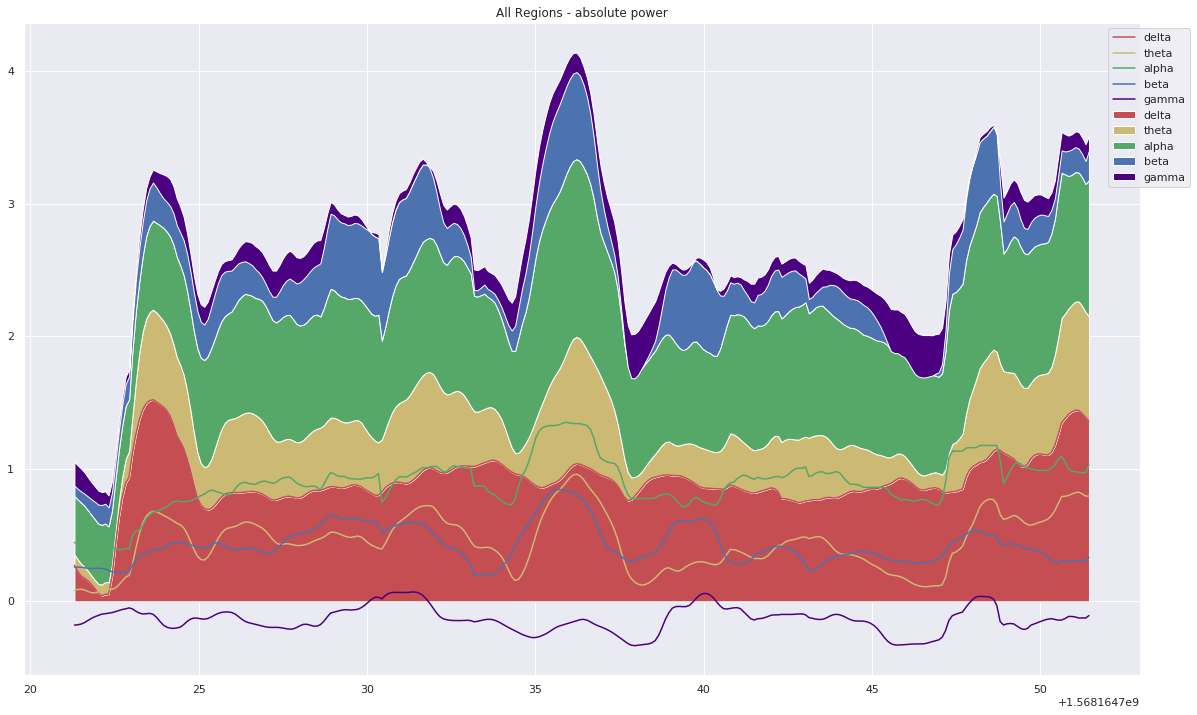

In [19]:
plot_bands()

### All Regions - Relative Power 

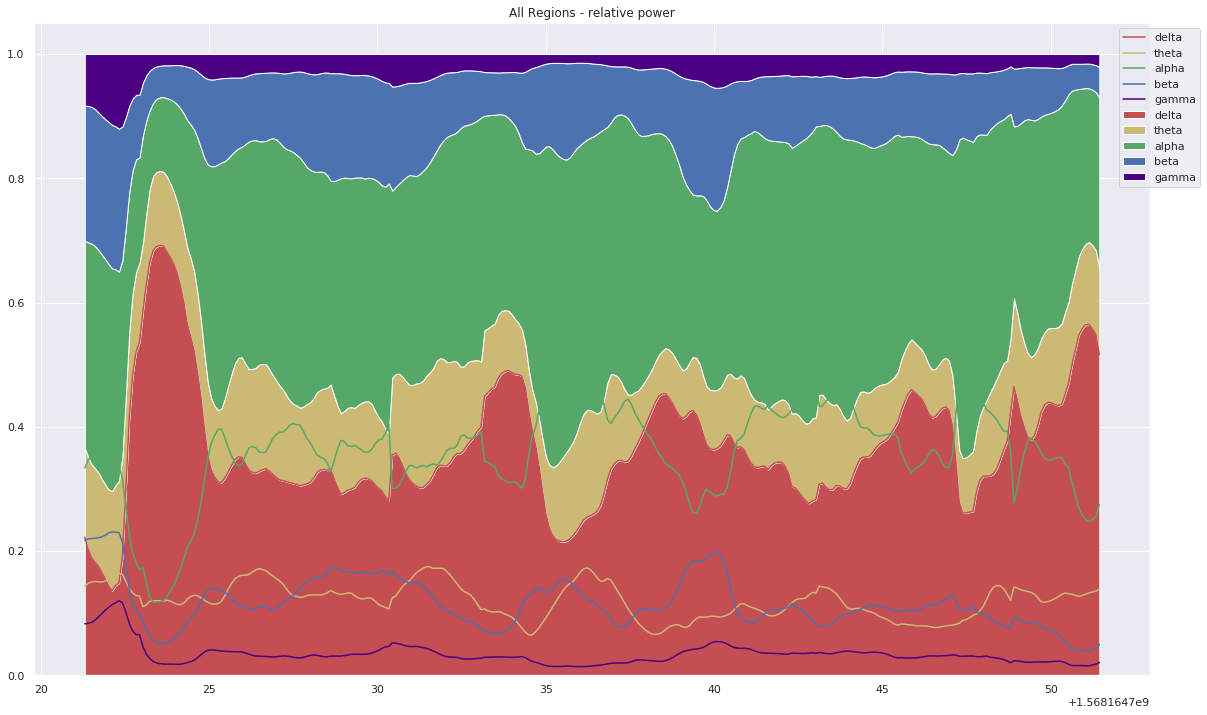

In [20]:
plot_bands('relative')

### By Region - Absolute Power

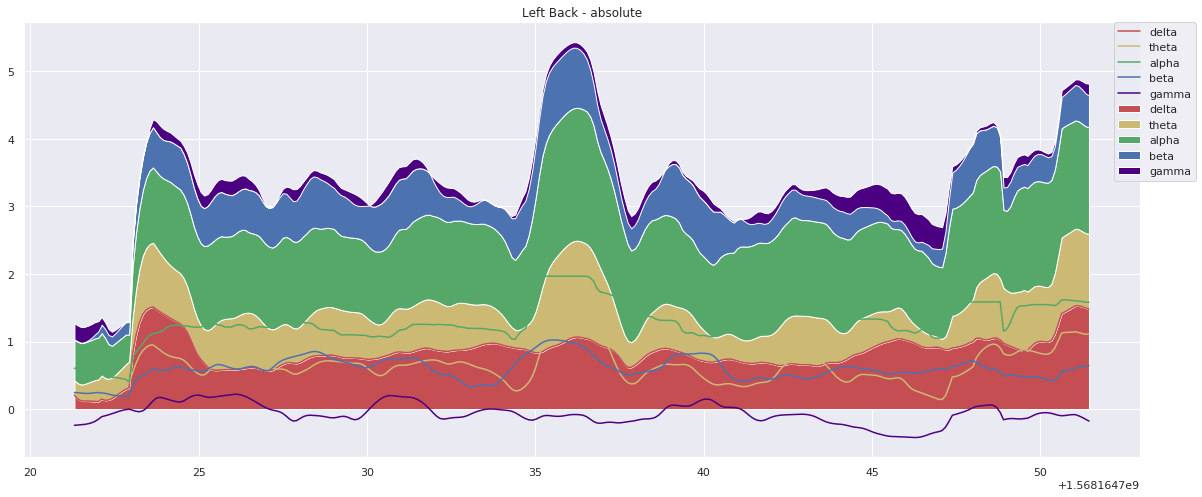

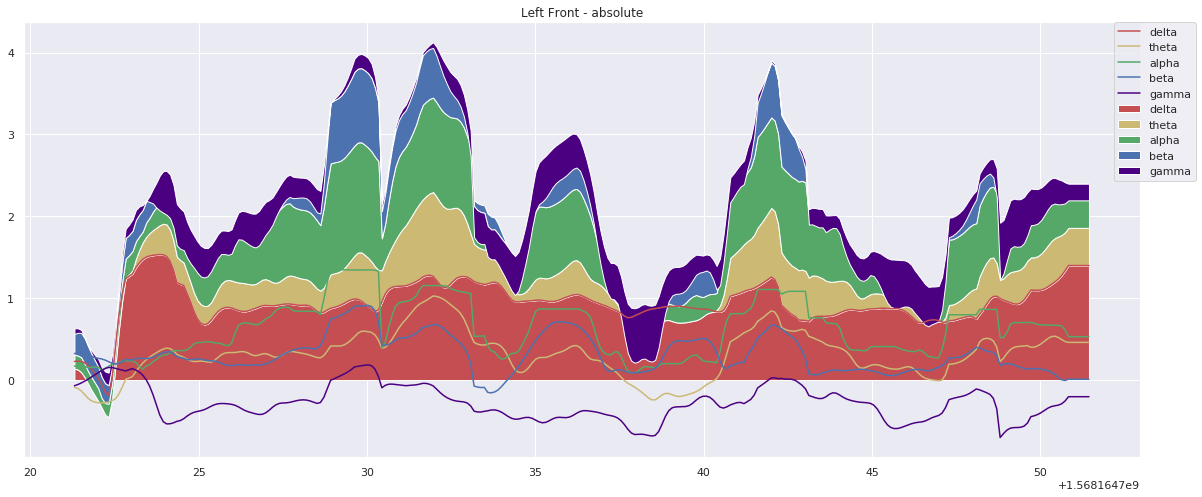

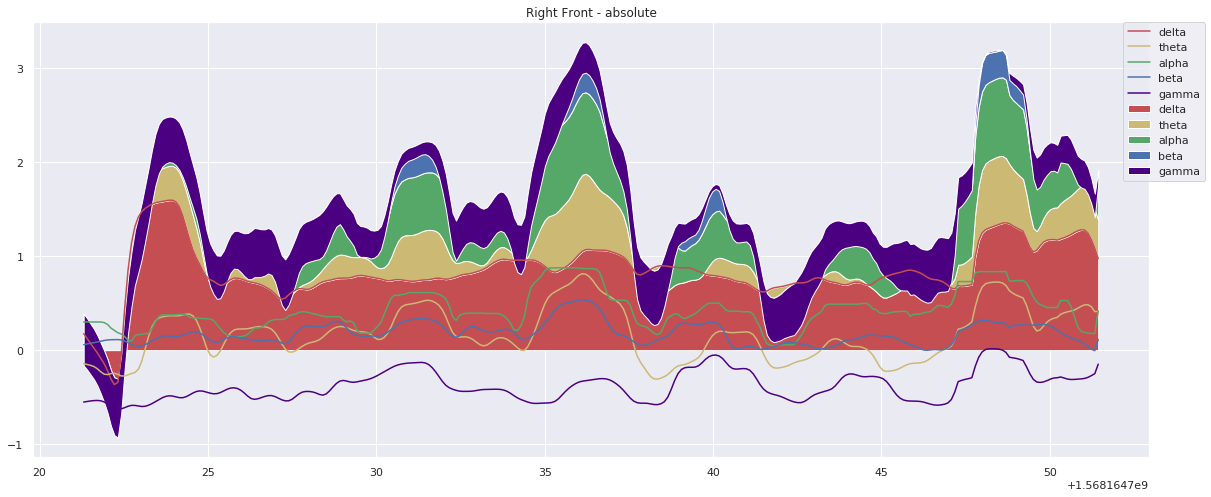

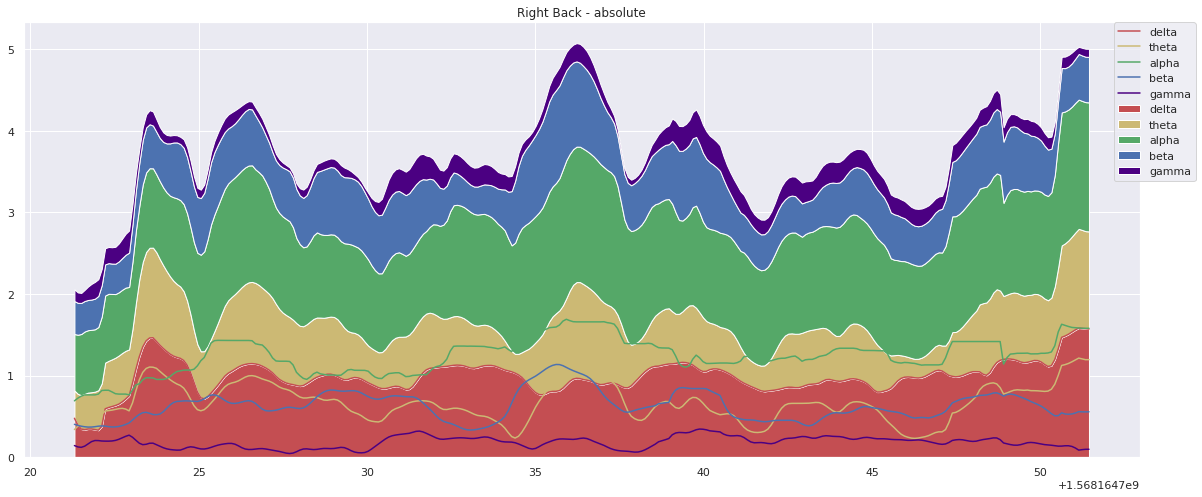

In [21]:
for i in range(1,5): plot_channel(str(i),'absolute')

### By Region - Relative Power 

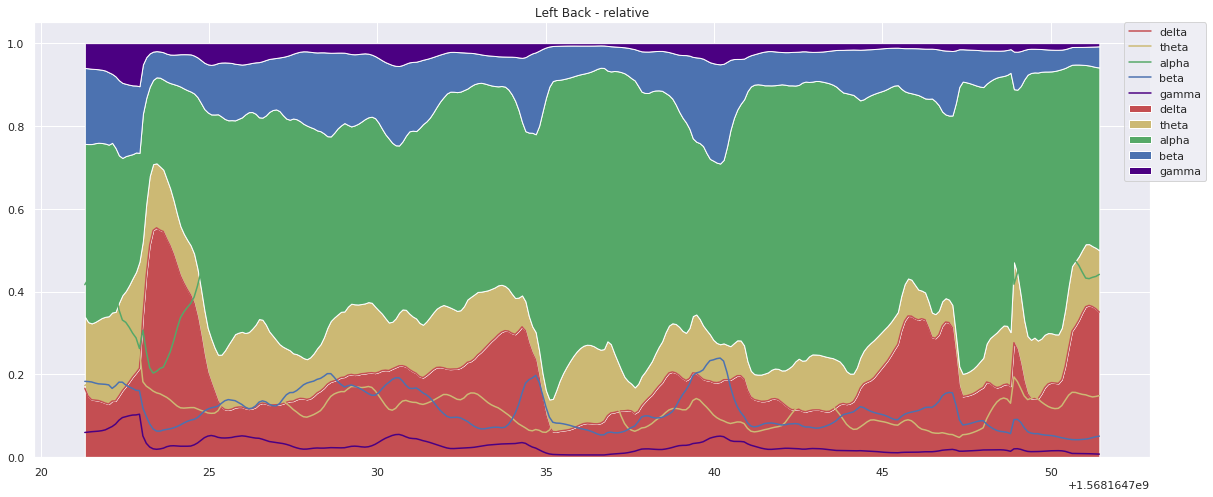

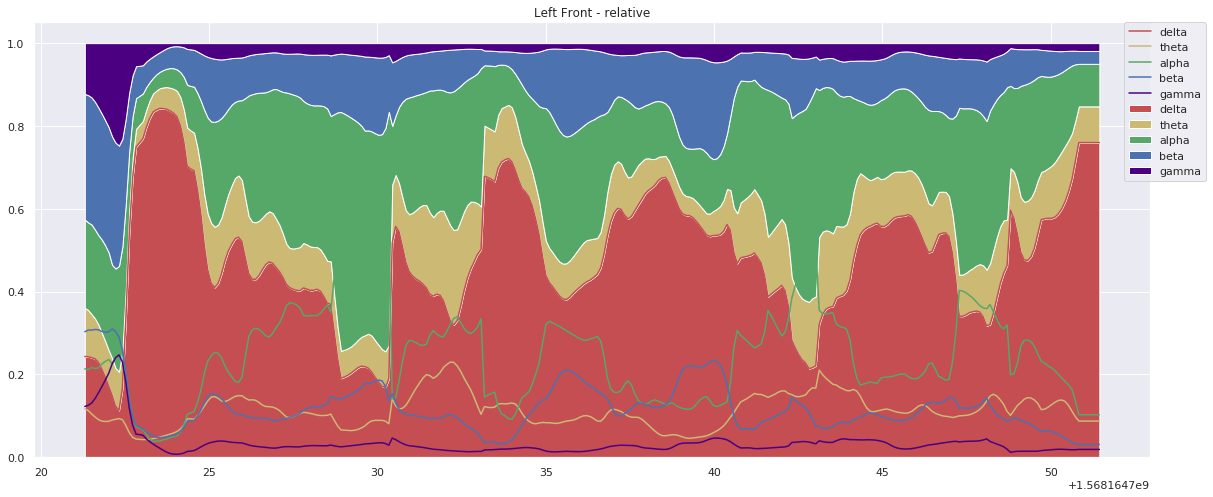

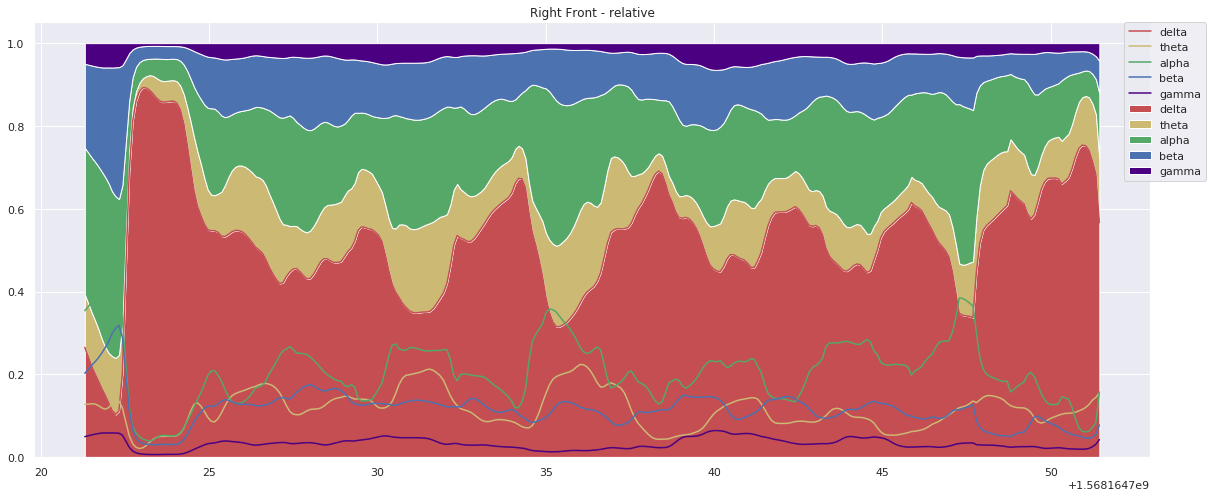

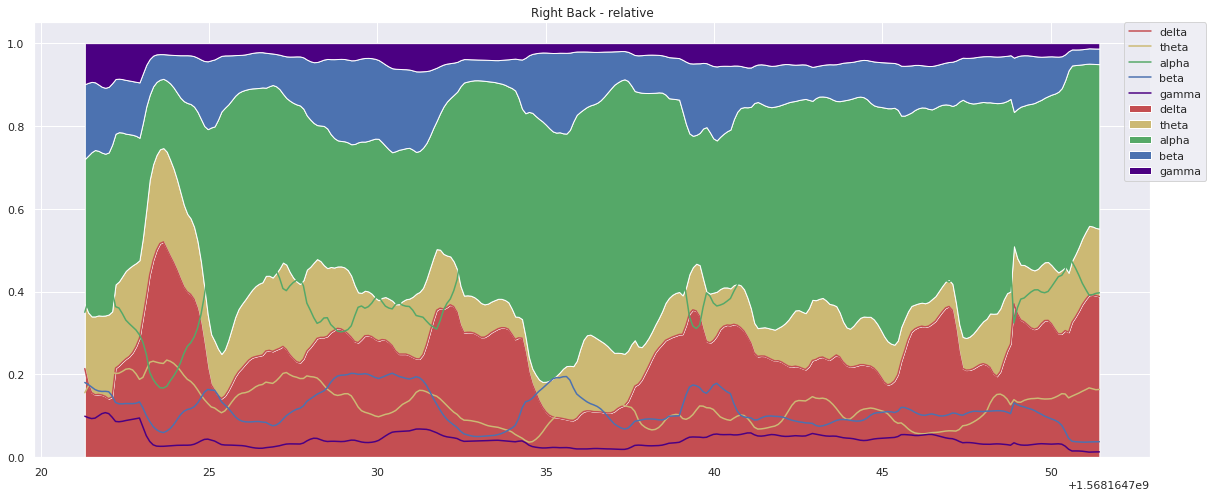

In [22]:
for i in range(1,5): plot_channel(str(i),'relative')

## Power Spectral Density 

In [176]:
from scipy import signal

SF = 256         # sampling frequency
WIN = 4 * SF  # window length (4 sec)

def spectral_density(data,low,high,scale,title):
    freqs, psd = signal.welch(data, SF, nperseg=WIN)
    
    # Find intersecting values in frequency vector
    idx_delta = np.logical_and(freqs >= low, freqs <= high)

    # Plot the power spectral density and fill the delta area
    plt.figure(figsize=(20, 4))
    plt.plot(freqs, psd, lw=2, color='k')
    plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
    plt.xlabel('Frequency (Hz)')
    plt.xlim([low-1, high+1])
    plt.ylim([0, psd.max() * scale])
    plt.title(title)
    sns.despine()

### Power Spectral Density (uV^2 / Hz) 

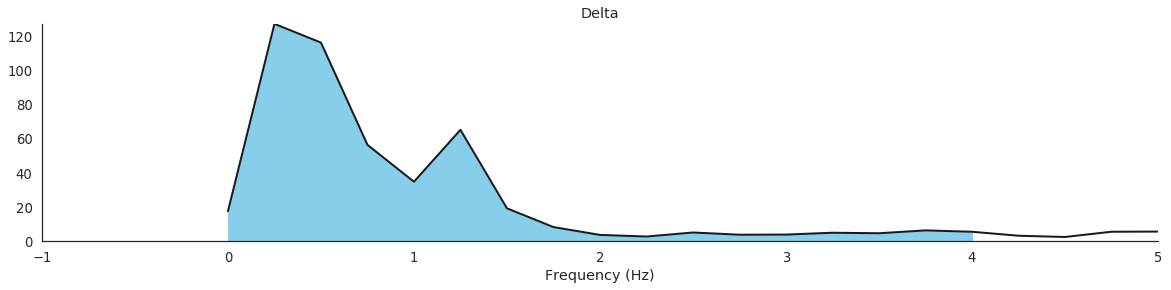

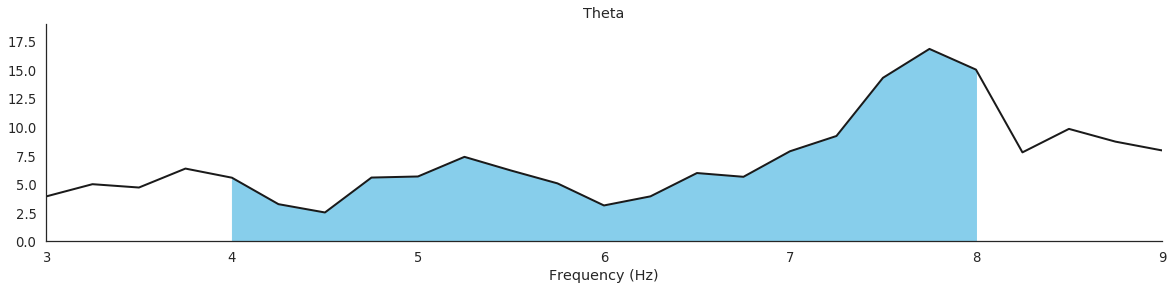

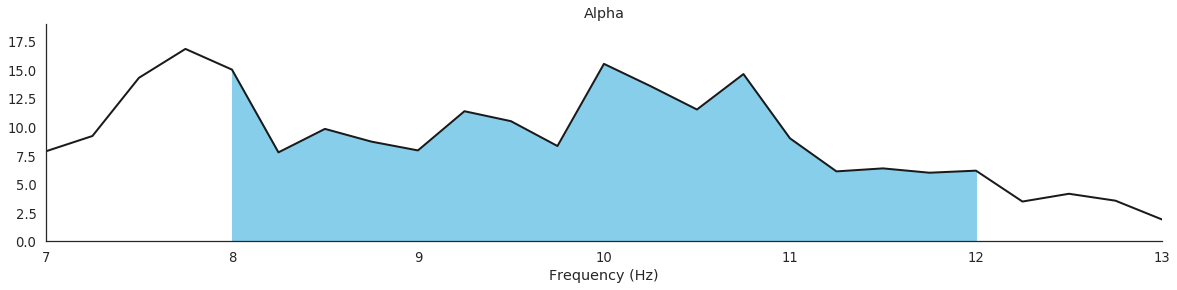

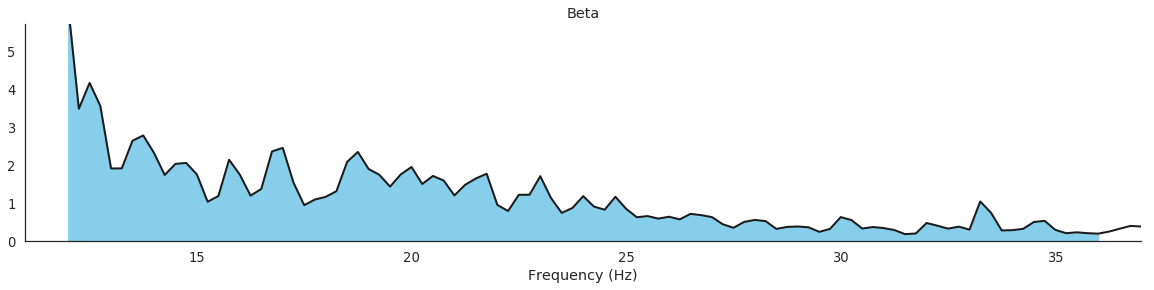

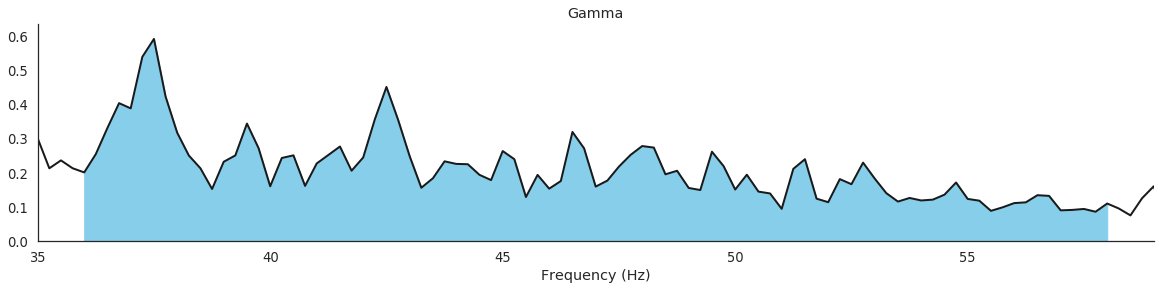

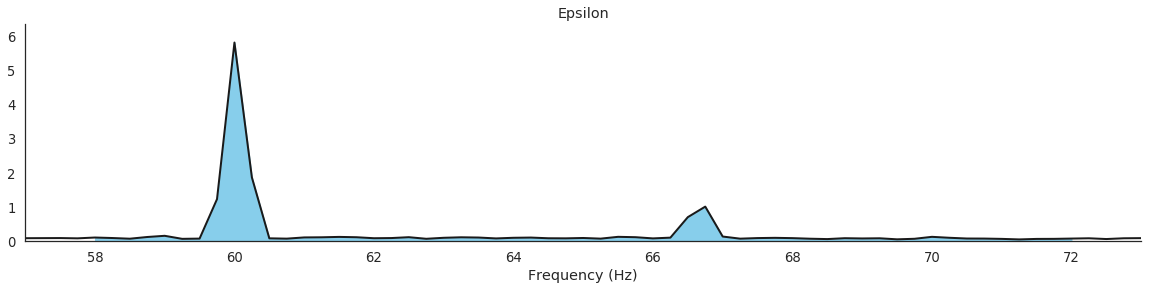

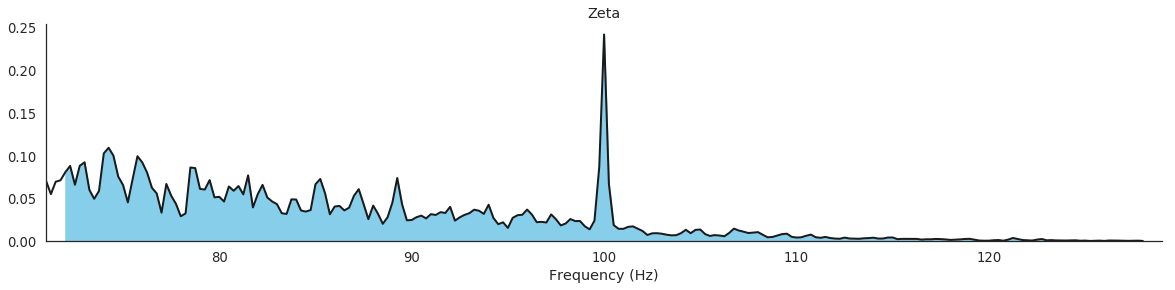

In [177]:
spectral_density(RECORDS['eeg_1'].dropna(),0,4,1,'Delta')
# spectral_density(RECORDS['eeg_2'].dropna(),0,4,1,'Delta')
# spectral_density(RECORDS['eeg_3'].dropna(),0,4,1,'Delta')
# spectral_density(RECORDS['eeg_4'].dropna(),0,4,1,'Delta')
spectral_density(RECORDS['eeg_1'].dropna(),4,8,.15,'Theta')
spectral_density(RECORDS['eeg_1'].dropna(),8,12,.15,'Alpha')
spectral_density(RECORDS['eeg_1'].dropna(),12,36,.045,'Beta')
spectral_density(RECORDS['eeg_1'].dropna(),36,58,.005,'Gamma')
spectral_density(RECORDS['eeg_1'].dropna(),58,72,.05,'Epsilon')
spectral_density(RECORDS['eeg_1'].dropna(),72,128,.002,'Zeta')